## Threshold sensitivity study
---
This notebook shows how retinal vessel segmentation performance of octave UNet respond to changing global threshold values.

In [1]:
# setup path environment
import os
import sys

project_dir, _ = os.path.split(os.getcwd())
if project_dir not in sys.path:
    sys.path.append(project_dir)

# import packages for data manipulation and drawing
import pandas as pd
import numpy as np
import scipy as sp

# for ploting inline on the notebook
from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style='whitegrid')
sns.set_context('paper', font_scale=1.5)

from PIL import Image
import torch
from torch.nn import functional as F
from torchvision.transforms import functional as TF


## DRIVE

In [2]:
def get_pil_images(exp_dir, sample_index, image_surfix, convert_mode, 
                   monitor_dir='last', outputs_dir='outs'):
    """Get images with sample index."""
    image_file = str(sample_index) + image_surfix
    image_path = os.path.join(exp_dir, outputs_dir, monitor_dir, image_file)
    pil_image = Image.open(image_path, mode='r').convert(convert_mode)
    return pil_image

from functools import partial
get_image = partial(get_pil_images, image_surfix='-images.png', convert_mode='RGB')
get_target = partial(get_pil_images, image_surfix='-targets.png', convert_mode='1')
get_probability_map = partial(get_pil_images, image_surfix='-probability_maps.png', convert_mode='L')
get_analytic = partial(get_pil_images, image_surfix='-analytic_maps.png', convert_mode='RGB')
get_binary_map = partial(get_pil_images, image_surfix='-binary_maps.png', convert_mode='1')
get_mask = partial(get_pil_images, image_surfix='-masks.png', convert_mode='1')

from src.processings.thresholdings import batch_thresholding
from src.agents.retina.utils.get_metrics import get_metrics

def get_sensitivity_curves(exp_dir, num_samples, leave_one_out=False, 
                           monitor_dir='last', outputs_dir='outs'):
    """Get sensitivity curves."""
    metric_names = ('acc', 'se', 'sp', 'f1')
    acc_list, se_list, sp_list, f1_list = [], [], [], []
    constants = list(np.arange(0.01, 1.0, 0.01))
    for constant in constants:
        acc, se, sp, f1 = 0.0, 0.0, 0.0, 0.0
        for sample_index in range(num_samples):
            if leave_one_out:
                exp_dir_full = os.path.join(exp_dir, 'valid_' + str(sample_index))
            else:
                exp_dir_full = exp_dir
            prob_map = TF.to_tensor(get_probability_map(exp_dir_full, sample_index, 
                                                        monitor_dir=monitor_dir, 
                                                        outputs_dir=outputs_dir))
            target = TF.to_tensor(get_target(exp_dir_full, sample_index, 
                                             monitor_dir=monitor_dir, 
                                             outputs_dir=outputs_dir))[None, :, :]
            binary_map = batch_thresholding(prob_map, thresh_mode='constant', constant=constant)
            metrics = get_metrics(metric_names, prob_map, binary_map, target)
            acc += metrics['acc']
            se += metrics['se']
            sp += metrics['sp']
            f1 += metrics['f1']
        acc_list.append(acc / num_samples)
        se_list.append(se / num_samples)
        sp_list.append(sp / num_samples)
        f1_list.append(f1 / num_samples)
    sensitivity_curves_df = pd.DataFrame({'threshold': constants, 'acc': acc_list, 
                                          'se': se_list, 'sp': sp_list, 'f1': f1_list})
    sensitivity_curves_df.set_index('threshold', inplace=True)
    return sensitivity_curves_df


In [3]:
drive_exp_dir = '../exps/ablation-study/alpha_0.5'
drive_num_samples = 20
drive_sen_df = get_sensitivity_curves(drive_exp_dir, drive_num_samples, False)


In [4]:
stare_exp_root = '../exps/datasets/stare'
stare_num_samples = 20
stare_sen_df = get_sensitivity_curves(stare_exp_root, stare_num_samples, True)


In [5]:
chase_exp_root = '../exps/datasets/chase'
chase_num_samples = 28
chase_sen_df = get_sensitivity_curves(chase_exp_root, chase_num_samples, True)


In [6]:
hrf_exp_root = '../exps/datasets/hrf'
hrf_num_samples = 45
hrf_sen_df = get_sensitivity_curves(hrf_exp_root, num_samples=hrf_num_samples, leave_one_out=True)



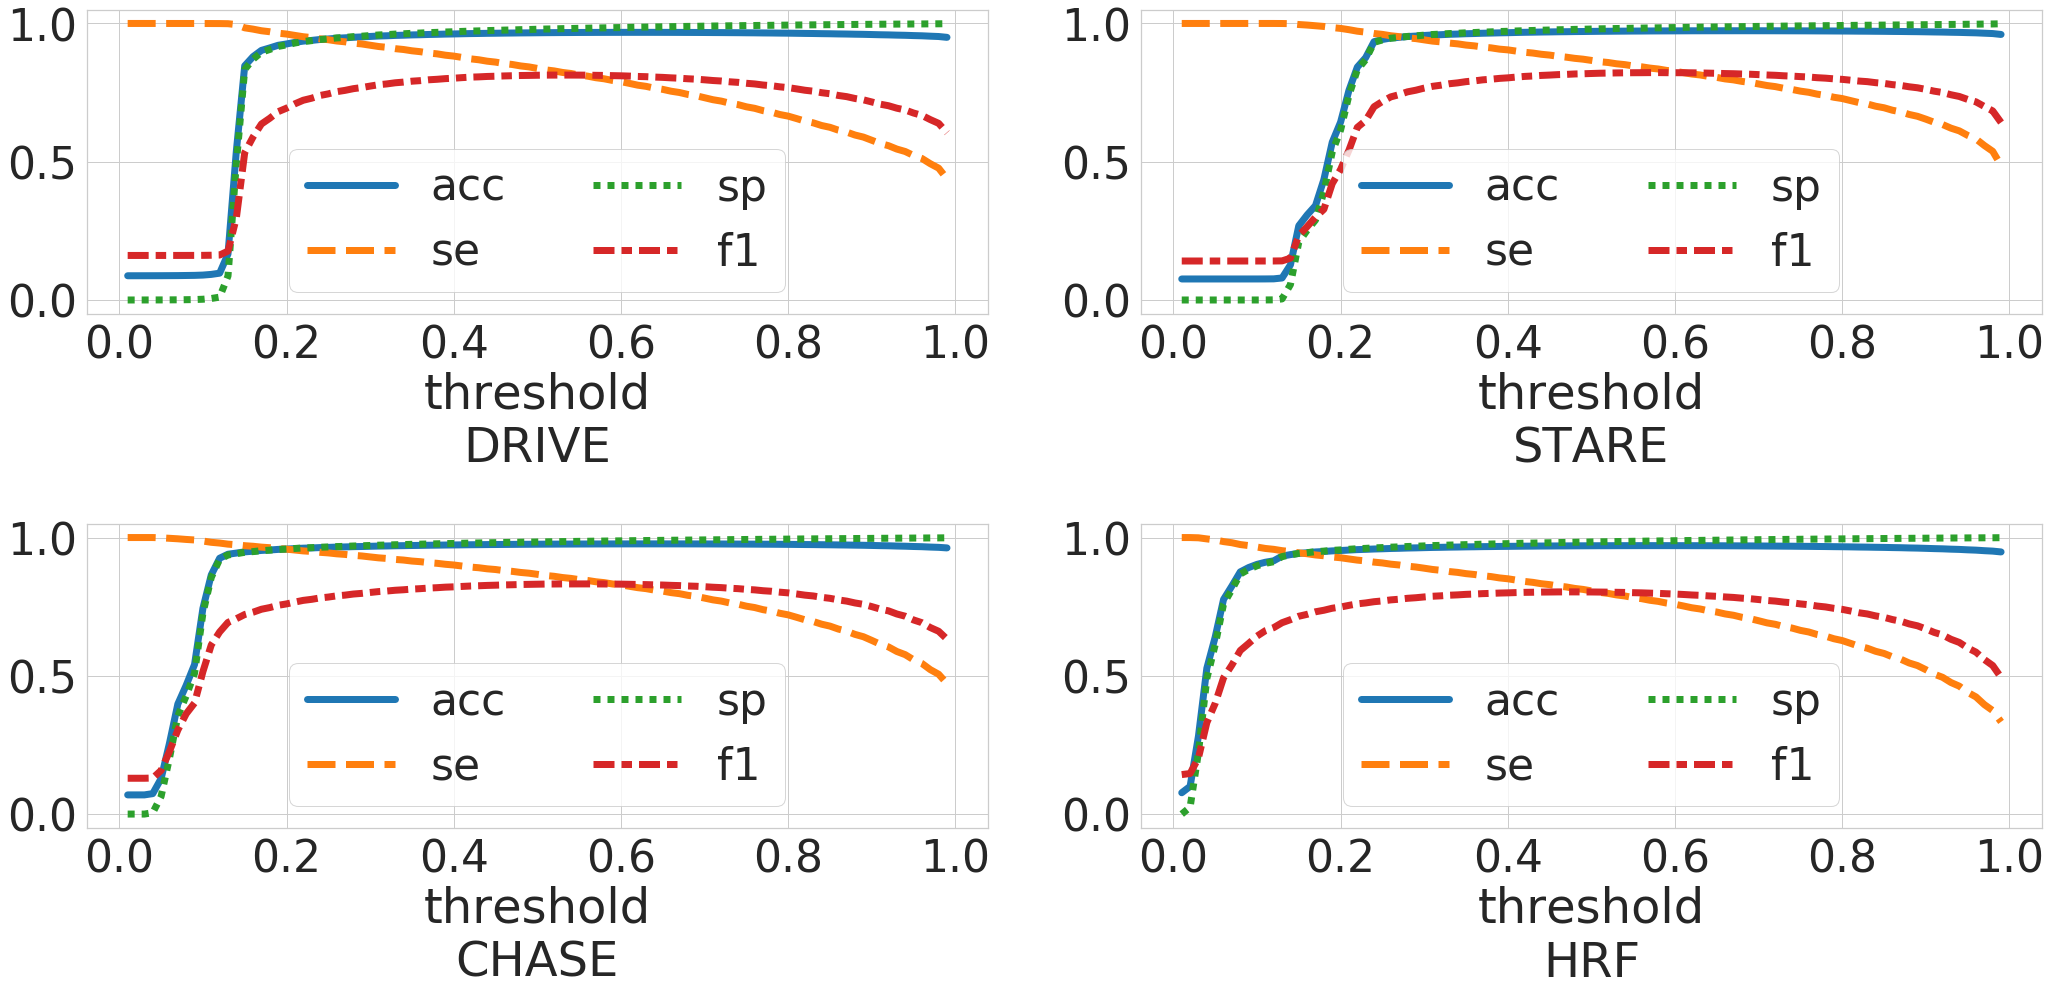

In [7]:
def compare_sensitivity_curves(data_frames, exp_names, 
                               save_fig=False, linewidth=7, font_scale=3.5):
    """Plot sensitivity curves."""
    assert len(data_frames) == len(exp_names)
    metric_names = ('acc', 'se', 'sp', 'f1')
    rows = int(len(data_frames) ** 0.5)
    cols = int(np.ceil(len(data_frames) / int(len(data_frames) ** 0.5)))
    sns.set(style='whitegrid', font_scale=font_scale)
    fig, axes = plt.subplots(rows, cols, figsize=(cols*15, rows*7.5))
    axes = axes.ravel()
    for idx, data_frame in enumerate(data_frames):
        g = sns.lineplot(data=data_frame, palette='tab10', linewidth=linewidth, ax=axes[idx])
        g.legend(loc='lower right', ncol=2)
        g.set(xlabel='threshold\n{}'.format(exp_names[idx]))
        g.legend(loc='best', ncol=2)
        for line in g.get_legend().get_lines():
            line.set_linewidth(linewidth)
#         if idx == len(data_frames) - 1:
#             g.legend(loc='best', ncol=2)
#         else:
#             g._remove_legend(g.get_legend())
#     for line in g.get_legend().get_lines():
#         line.set_linewidth(linewidth)
    plt.tight_layout()
    if save_fig: 
        try:
            os.mkdir('cases')
        except:
            pass
        fig.savefig('cases/sensitivity-curves.pdf')
    plt.show()
    sns.set(style='whitegrid')
    sns.set_context('paper', font_scale=1.5)
    
compare_sensitivity_curves(data_frames=(drive_sen_df, stare_sen_df, chase_sen_df, hrf_sen_df), 
                           exp_names=('DRIVE', 'STARE', 'CHASE', 'HRF'), 
                           save_fig=False, linewidth=7, font_scale=4)

In [18]:
drive_sen_df.loc[0.55]

acc    0.967414
se     0.813484
sp     0.982504
f1     0.813224
Name: 0.55, dtype: float64

In [27]:
stare_sen_df.loc[0.62]

acc    0.973477
se     0.817181
sp     0.986251
f1     0.821525
Name: 0.62, dtype: float64